(first-energydata-analysis)=
# Erste Energiedatenanalyse

:::{admonition} **Lernziele**
- Erste Energiedaten analysieren
- mit öffentlich verfügbaren Beispiel-Energiedaten und python-Datenanalysewerkzeugen
- um die Vorgehensweise mit python kennenzulernen und dies in den Projekten anwenden zu können
:::

## python konfigurieren

### Module importieren

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import datetime as dt
import seaborn as sns
import shutil
from cycler import cycler
from collections.abc import Iterable
from sklearn import linear_model
from jupytercards import display_flashcards
from jupyterquiz import display_quiz
import pygit2
print('Versionen der verwendeten python-Module: ')
print('numpy', np.__version__)
print('matplotlib', matplotlib.__version__)
print('pandas', pd.__version__)
print('datetime', dt)
print('seaborn', sns.__version__)
print('shutil',shutil)
print('cycler',cycler)
print('pygit2', pygit2.__version__)

Versionen der verwendeten python-Module: 
numpy 2.1.1
matplotlib 3.9.2
pandas 2.2.3
datetime <module 'datetime' from '/home/franzi/.pyenv/versions/miniconda3-latest/lib/python3.12/datetime.py'>
seaborn 0.13.2
shutil <module 'shutil' from '/home/franzi/.pyenv/versions/miniconda3-latest/lib/python3.12/shutil.py'>
cycler <function cycler at 0x7f8647577d80>
pygit2 1.15.1


### Grafikparameter einstellen

In [2]:
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

if shutil.which('latex'):
    plt.rcParams['text.usetex'] = True

### Funktionen definieren

Das zu verwendende Farbschema, angelehnt an [farbenblindenfreundlichen Farben](https://personal.sron.nl/~pault/#sec:qualitative), kann über eine der im folgenden gelisteten Einstellungen gewählt werden:

In [3]:
# define different color schemes according to:
# https://personal.sron.nl/~pault/#sec:qualitative

BRIGHT = ['#4477aa', '#66ccee', '#228833', '#ccbb44',
          '#ee6677', '#aa3377', '#bbbbbb']

HIGH_CONTRAST = ['#ffffff', '#ddaa33', '#bb5566', '#004488',
                 '#000000']

VIBRANT = ['#0077bb', '#33bbee', '#009988', '#ee7733',
          '#cc3311', '#ee3377', '#bbbbbb']

MUTED = ['#332288', '#88ccee', '#44aa99', '#117733',
         '#999933', '#ddcc77', '#cc6677', '#882255', '#aa4499',
         '#dddddd']

MEDIUM_CONTRAST = ['#ffffff', '#eecc66', '#ee99aa', '#6699cc',
                   '#997700', '#994455', '#004488', '#000000']

LIGHT = ['#77aadd', '#99ddff', '#44bb99', '#bbcc33',
         '#aaaa00', '#eedd88', '#ee8866', '#ffaabb', '#dddddd']

ALL_SCHEMES_KEYS = ['BRIGHT',
               'HIGH_CONTRAST',
               'VIBRANT',
               'MUTED',
               'MEDIUM_CONTRAST',
               'LIGHT']

ALL_SCHEMES_VALS = [BRIGHT,
                    HIGH_CONTRAST,
                    VIBRANT,
                    MUTED,
                    MEDIUM_CONTRAST,
                    LIGHT]

ALL_SCHEMES_DICT = dict(zip(ALL_SCHEMES_KEYS, ALL_SCHEMES_VALS))

def set_colors(scheme):
    if scheme not in ALL_SCHEMES_KEYS:
        raise ValueError(f"scheme not spported yet, needs to be either of\n\
        {[name for name in ALL_SCHEMES_KEYS]}")
    rcParams['axes.prop_cycle'] = cycler('color', ALL_SCHEMES_DICT[scheme])

In [4]:
set_colors('BRIGHT')

Die folgende Funktion ermöglicht es, die Achsenskalierung besser anzupassen.

In [5]:
class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype(int).values
            
        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs
    
def set_date_ticks(ax, start_date, end_date, axis='y', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))

    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

## Energiedaten in jupyter notebook einlesen: Beispiel-Datensatz

unter {cite:p}`minde_household_2017` den Datensatz vom 10.11.2017 in einminütiger Auflösung im Jupyter Notebook Verzeichnis im Unterverzeichnis data speichern.

über den Datensatz gibt es weitere Infos im [Readme](https://data.open-power-system-data.org/household_data/2017-11-10/README.md)

falls Sie den Datensatz verwenden, ist es (wie auch bei allen anderen fremden Datensätzen!) Pflicht, diesen zu zitieren, die Autoren haben dafür sogar einen Vorschlag, den ich übernommen habe

## Nützliche python-Module

<b>*pandas*</b> für Datenanalyse<br>
<b>*numpy*</b> für Berechnungen<br>
<b>*matplotlib*</b> für Diagramme<br>
<b>*datetime*</b> für Datumsformate<br>
<b>*seaborn*</b> für hübsche Diagramme

## Daten laden

In [6]:
df = pd.read_csv('../data/household_data_1min_singleindex.csv')

zu finden unter: https://data.open-power-system-data.org/household_data/2020-04-15 {cite:p}`minde_household_2017`

generell: stellen Sie im Dateiexplorer ein, dass Sie Dateiendungen sehen wollen (z. B. `xy.csv` statt `xy`)

Unter Microsoft Windows kann man Dateiendungen folgendermaßen einblenden: Systemsteuerung $\to$ Erscheinungsbild und Personalisierung $\to$ Ordneroptionen oder Dateiexploreroption $\to$ Ansichts-Tab, dort unter erweiterte Einstellungen die Option *Für bekannte Dateiformate Dateiendungen verbergen* deaktivieren, dann anwenden und OK klicken.

Unter Mac OS: Finder öffnen $\to$ im Menü Preferences klicken $\to$ Erweitert (Advanced), dort anklicken *alle Dateiendungen anzeigen*.

## aktuellen Pfad in python finden

aktuelles Verzeichnis finden (bitte selbst ausprobieren, mein aktuelles Verzeichnis ist hier nicht abgedruckt!)

`import os`

`print(os.getcwd())`

In [7]:
# hier selbst ausprobieren

alle Dateien und Ordner im Verzeichnis anzeigen - diese sind direkt mit pandas oder python verfügbar (ohne Pfad)

In [8]:
import os
print(os.listdir(os.getcwd()))

['.ipynb_checkpoints', '03SYE.ipynb', 'Beispiel_Datenanalyse.ipynb', 'dateiorga-thk-jupyterhub.ipynb', 'SYE-first-energydata-analysis.ipynb', 'SYE-python-intro.ipynb']


### relative Pfadangabe in python

mit `..` kommt man ein Verzeichnis höher, z. B. `../` ist nur eine Ebene drüber, dort kann man dann das Verzeichnis, dass man öffnen will eingeben

mit Angabe des Verzeichnis in Anführungszeichen (hier jetzt `systemtechnik-fuer-energieeffizienz`) kommt man dort hinein

In [9]:
# print(os.listdir("../../systemtechnik-fuer-energieeffizienz"))

### absolute Pfadangabe in python

in Windows z. B. `"C:/Dokumente/Susanne/Daten/Test_Datei.csv"`

in Mac oder Linux z. B. `"/home/username/data/energydata/testdata.csv"`

immer in Anführungszeichen

relative Pfade sind besser, denn wenn Ihr Kollege im Projekt die gleiche Datenstruktur hat (z. B. das Notebook in einer Ebene und die Datensätze dort im Verzeichnis `daten/`) dann funktionieren auch die Notebooks weiter

## erster Überblick über die Daten: Anfang

In [10]:
# df.head()

## und Ende

In [11]:
# df.tail()

## Statistik

In [12]:
# df.describe()

## Größe des Datensatzes

In [13]:
# len(df)

Das ist die Anzahl der Datensätze.

## Datentypen überprüfen

In [14]:
# print(df.dtypes)

:::{admonition} **AUFGABE**
Welche Datentypen erkennen Sie im Datensatz, welche nicht?
:::

*Antwort:...*

## python datetime Objekt

In [15]:
a = dt.datetime(2017, 11, 11)
print(a)

2017-11-11 00:00:00


Mindestangabe für datetime: Jahr, Monat, Tag, weiteres optional:

In [16]:
b = dt.datetime(2017, 11, 11, 11, 11, 11, 11)
print(b)

2017-11-11 11:11:11.000011


### Jahr, Monat, Tag und Zeitstempel ausgeben

In [17]:
a = dt.datetime(2017, 1, 2, 3, 4, 5, 6)
print("Jahr: ", a.year)
print("Monat: ", a.month)
print("Tag: ", a.day)
print("Zeitstempel: ", a.timestamp())

Jahr:  2017
Monat:  1
Tag:  2
Zeitstempel:  1483322645.000006


### Datumswerte konvertieren

USA: mm/dd/yyyy<br>
EU: dd/mm/yyyy<br>
`strftime()` datetime $\to$ string<br>
`strptime()` string $\to$ datetime

### Datumsformat in `datetime` mit `strptime()` konvertieren

In [18]:
datums_string = "11 November, 2021"
print("datums_string = ", datums_string)

datums_string =  11 November, 2021


In [19]:
datums_object = dt.datetime.strptime(datums_string, "%d %B, %Y")
print("datums_object = ", datums_object)

datums_object =  2021-11-11 00:00:00


## Datumswerte in unserem Beispiel

In [20]:
#print(df.utc_timestamp.head())

Format `%Y-%m-%dT%H%M%SZ` laut Readme

### Datumswerte in unserem Beispiel konvertieren

In [21]:
df['zeit'] = df.utc_timestamp.apply(#
    lambda x: #
    dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
print(df['zeit'].head())

0   2015-10-26 12:31:00
1   2015-10-26 12:32:00
2   2015-10-26 12:33:00
3   2015-10-26 12:34:00
4   2015-10-26 12:35:00
Name: zeit, dtype: datetime64[ns]


`datetime64[ns]` steht für die Speicherung in Nanosekunden

In [22]:
#repository_name = Repository('.').head.shorthand  # gibt den Namen des aktuellen repo wieder
repository_name = 'master'
quiz_main_path = 'https://gitlab.com/oer4renewables/systemtechnik-fuer-energieeffizienz/-/raw/'+ repository_name + '/files/quiz/'
quiz_name = '2_2_Erste_Energiedatenanalyse_cards.json'

display_quiz(quiz_main_path + quiz_name)

<IPython.core.display.Javascript object>

## Daten in einem Diagramm darstellen

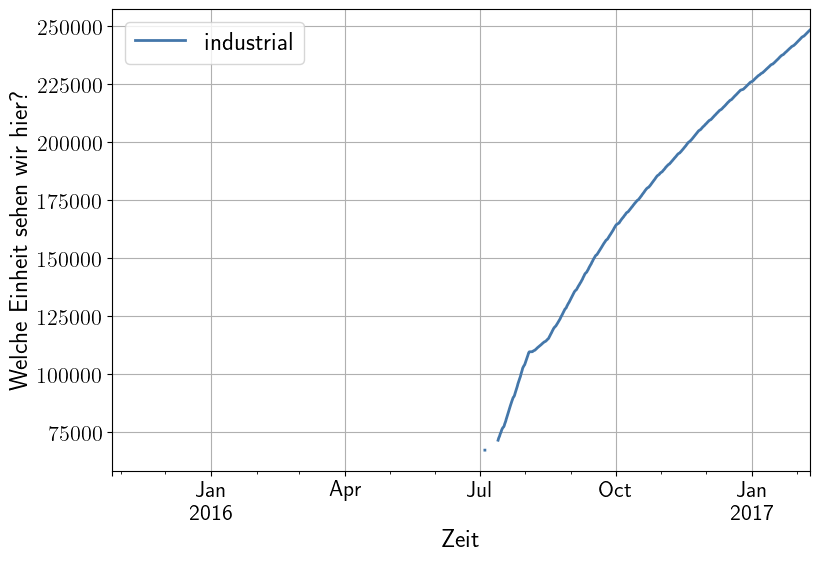

In [23]:
df.rename(columns = {'DE_KN_industrial1_grid_import':'industrial'}, inplace = True)
df.plot(x = 'zeit', y = 'industrial', figsize=(9,6))
plt.xlabel('Zeit')
plt.ylabel('Welche Einheit sehen wir hier?');
plt.grid()
plt.show()

:::{admonition} **AUFGABE**
Was sehen wir in diesem Diagramm? Welche Einheit?
:::

*Antwort:...*

nach {cite:p}`walker_tutorial_2019`

### Spalten für Jahr, Monat, Tag, etc. einfügen

In [24]:
df['Jahr'] = df['zeit'].dt.year
df['Monat'] = df['zeit'].dt.month
df['Wochentag'] = df['zeit'].dt.weekday

In [25]:
# df.sample(5)

## Stromlastprofil eines Industrieunternehmens

In [26]:
df['industrialP'] = df['industrial'].diff()

In [27]:
df.plot(x='zeit',y='industrialP', figsize=(9,6))
plt.grid()
plt.show()

wobei die y-Achsenbeschriftung noch fehlt: aus dem [Readme des Datensatzes](https://data.open-power-system-data.org/household_data/2017-11-10/README.md) ergibt sich die Energieeinheit zu kWh

x-Achse müsste Anzahl der Werte bezogen auf die Auflösung ergeben

In [28]:
res = df['zeit'][1]-df['zeit'][0]
print('Auflösung '+str(res))

Auflösung 0 days 00:01:00


d.h. die y-Achse hat momentan die Einheit $[dW/dt] = 1\text{ kWh/min.}$ 

In [29]:
dW = 1000*60*60 # kWh in J
dt = 60 # min. in sec
dW_dt_faktor = dW/dt
print('Umrechnungsfaktor zu W ist ' + str(dW_dt_faktor))

Umrechnungsfaktor zu W ist 60000.0


besser ist also, das gleich richtig zu berechnen:

In [30]:
df['industrialP'] = dW_dt_faktor*0.001*df['industrial'].diff()

In [31]:
df.plot(x='zeit',y='industrialP', figsize=(9,6))
plt.ylabel('Leistung [kW]')
plt.grid()
plt.show()

Schwer zu lesen mit so vielen Datenpunkten und leider ist die x-Achse voll mit fehlenden Daten.
Die Achse wird nicht gut ausgenutzt.

Fehlende Werte (`NaN`) weglassen:

In [32]:
df2 = df.dropna(subset=['zeit','industrialP'])

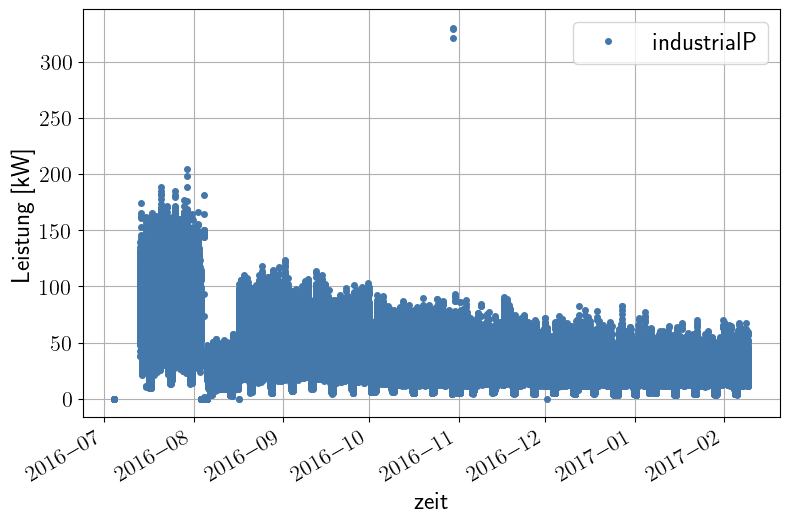

In [33]:
df2.plot(x='zeit',y='industrialP', style='.', figsize=(9,6))
plt.ylabel('Leistung [kW]')
plt.grid()
plt.show()

## Dauerlinie

In [34]:
sorted_industrial = sorted(df2['industrialP'], reverse = True)

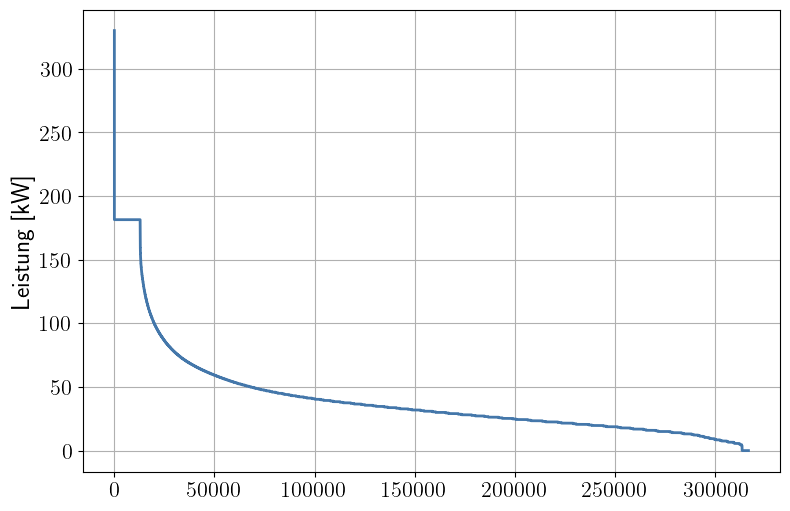

In [35]:
plt.figure(figsize=(9,6))
plt.plot(df2.index-df2.index[0],sorted_industrial)
plt.ylabel('Leistung [kW]')
plt.grid()
#plt.show()

Was sehen wir hier?

zum Vergleich: Minuten in einem Jahr:

In [36]:
no_min_year = 365*24*60
print(no_min_year)

525600


Eine Dauerlinie hat meist drei Bereiche mit Hinweisen für rationellere Energieverwendung:
1. Spitzenlasten, die verschoben werden können
2. unnötige Standby-Verbräuche
3. den mittleren Bereich

In [37]:
#plt.figure(figsize=(9,6))
#plt.plot(df2.index-df2.index[0],sorted_industrial)
#plt.xlabel('Anzahl Minuten')
#plt.ylabel('Leistung [kW]')
#plt.text(10000,300,'Spitzenlastverschiebung', fontsize=15)
#plt.text(80000,120,'allgemein effizientere Prozesse', fontsize=15)
#plt.text(210000,60,'Standby reduzieren', fontsize=15)
#plt.grid()
#plt.show()

In [38]:
#repository_name = Repository('.').head.shorthand  # gibt den Namen des aktuellen repo wieder
repository_name = 'master'
quiz_main_path = 'https://gitlab.com/oer4renewables/systemtechnik-fuer-energieeffizienz/-/raw/' + repository_name + '/files/quiz/'
quiz_name = '2_2_Erste_Energiedatenanalyse.json'

display_quiz(quiz_main_path + quiz_name)

<IPython.core.display.Javascript object>

## Vergleich mit lokaler Solarerzeugung

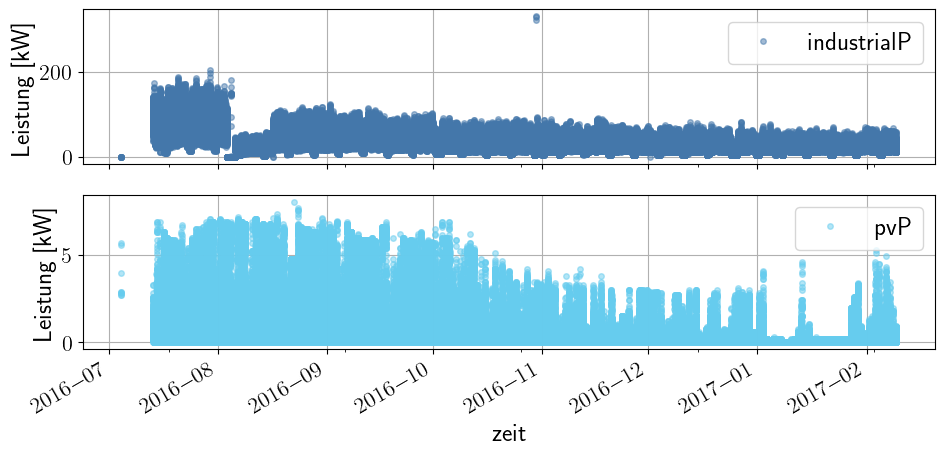

In [39]:
df.rename(columns = {'DE_KN_industrial1_pv_1':'pv'}, inplace = True)
df['pvP'] = dW_dt_faktor*0.001*df['pv'].diff()
df2 = df.dropna(subset=['zeit','industrialP','pvP'])

axes = df2.plot(x = 'zeit', y= ['industrialP','pvP'], marker='.',#
                         alpha=0.5, linestyle='None',#
                         figsize=(11,5), subplots=True, grid=True)
for ax in axes:
    ax.set_ylabel('Leistung [kW]')

:::{admonition} **AUFGABE**
Was sehen Sie? Was fällt auf?
:::

*Antwort:...*

## Stromlastprofil Januar 2017 genauer ansehen

erst mal als Index den Zeitstempel einstellen

In [40]:
df2.set_index('zeit', inplace = True)

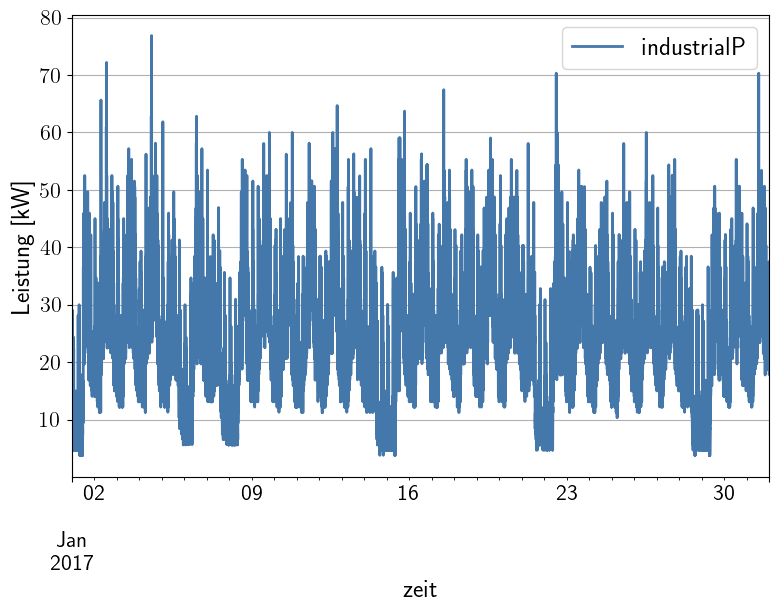

In [41]:
ax = df2.loc['2017-1'].plot(y = 'industrialP',linestyle='-', figsize=(9,6))
plt.ylabel('Leistung [kW]')
plt.grid()
plt.show()

höchster Stromverbrauch an Wochentagen und niedrigster unter der Woche?

### Wochentage aus matplotlib

In [42]:
import matplotlib.dates as mdates

### Wöchentliches Gitter im Diagramm

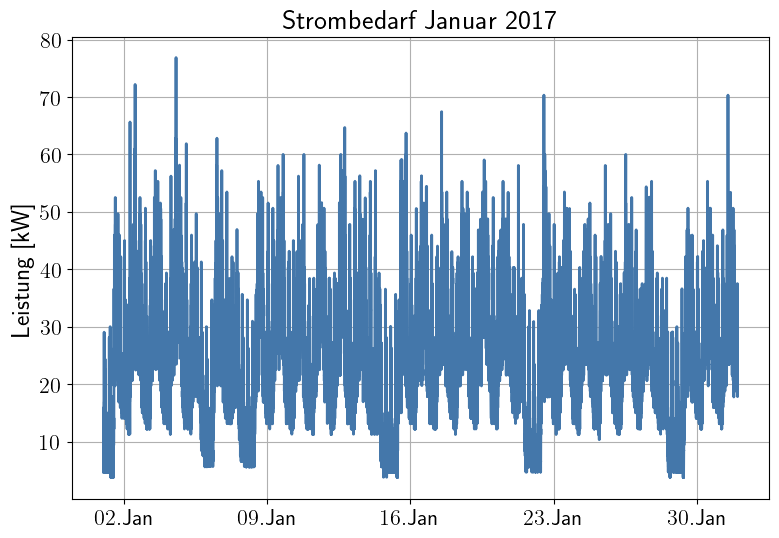

In [43]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df2.loc['2017-1', 'industrialP'], linestyle='-')
ax.set_ylabel('Leistung [kW]')
ax.set_title('Strombedarf Januar 2017')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%b'))
plt.grid()
plt.show()

hier scheint auch sonntags ein erhöhter Bedarf zu sein - das kann man hinterfragen, wenn man den Betrieb kennt und herausfinden, ob z. B. sonntags gearbeitet wird

## Jahreszeitliche Schwankungen mit Boxplots

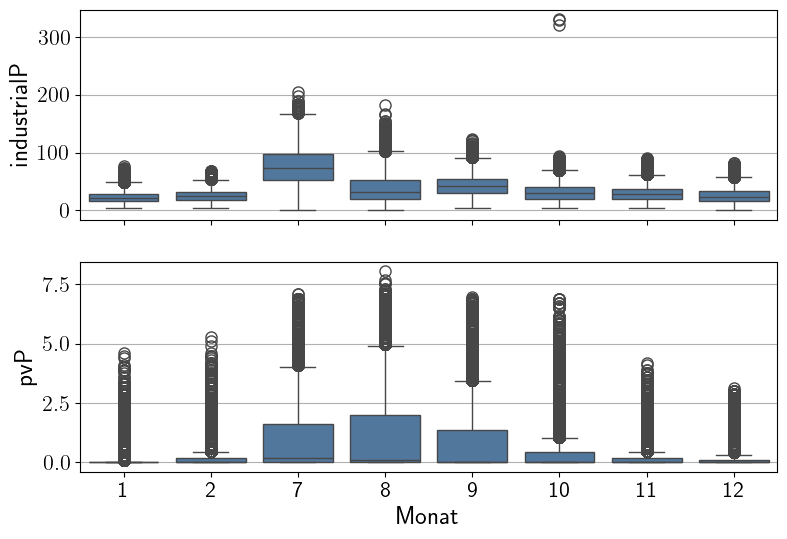

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

for name, ax in zip(['industrialP', 'pvP'], axes):
    ax.grid()
    sns.boxplot(data=df2, x='Monat', y=name, ax=ax)
if ax != axes[-1]:
    ax.set_xlabel('')

Über einige Monate lässt sich keine Aussage treffen, aufgrund fehlender Daten.

Die Solarerzeugung ist naturgemäß im Sommer höher als im Winter. Das ist plausibel.

Falls mehr Solarfläche vorhanden wäre (z. B. weitere Dachflächen, Fassaden, ggf. auch gemietet), könnte der Anteil lokaler Erzeugung erhöht werden.

Schön ist, dass im Sommer offenbar auch ein höherer Bedarf besteht, so dass eine erhöhte Solarerzeugung diesen auch verringern könnte.

## Wochentagsabhängigkeit des Lastprofils

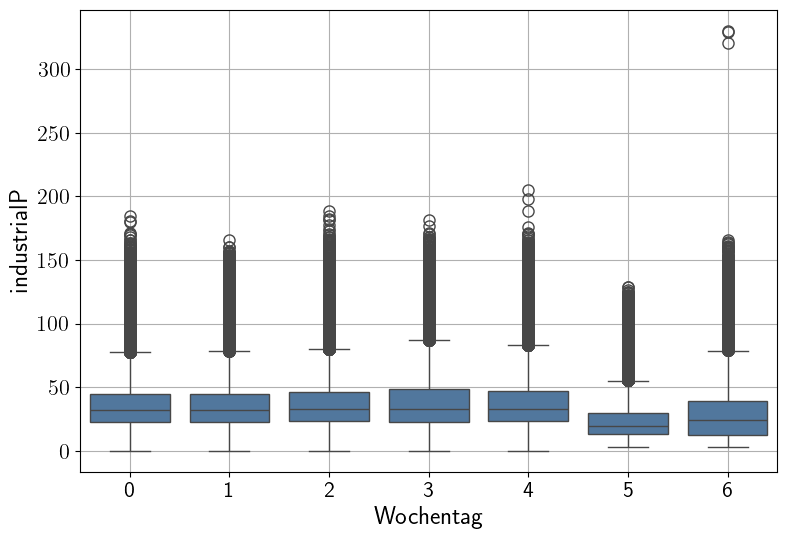

In [45]:
plt.figure(figsize=(9,6))
sns.boxplot(data = df2, x = 'Wochentag', y= 'industrialP');
plt.grid()

Hier sieht man, dass der Verbrauch deutlich geringer ist am Wochenende, dass es aber ein paar extreme Leistungswerte dann gibt. D.h. entweder geschieht dann ein Hochlauf mit hohem Bedarf oder es handelt sich um vermeidbare Leistungswerte.

## Gleitende Mittelwerte bilden: Fensterung von Daten (*Windowing*)

Im Fenster wird z. B. der Mittelwert gebildet, dann bewegt sich das Fenster einen Wert weiter, es wird
wieder ein Mittelwert gebildet etc.

Je größer das Fenster gewählt ist, desto mehr benachbarte Werte werden zur Berechnung des Mittelwerts herangezogen. 

In [46]:
df2_1d = df2['industrialP'].rolling(24*60, center=True).mean()

Fensterungsergebnis, wöchentlicher Mittelwert und Tageswert im Vergleich

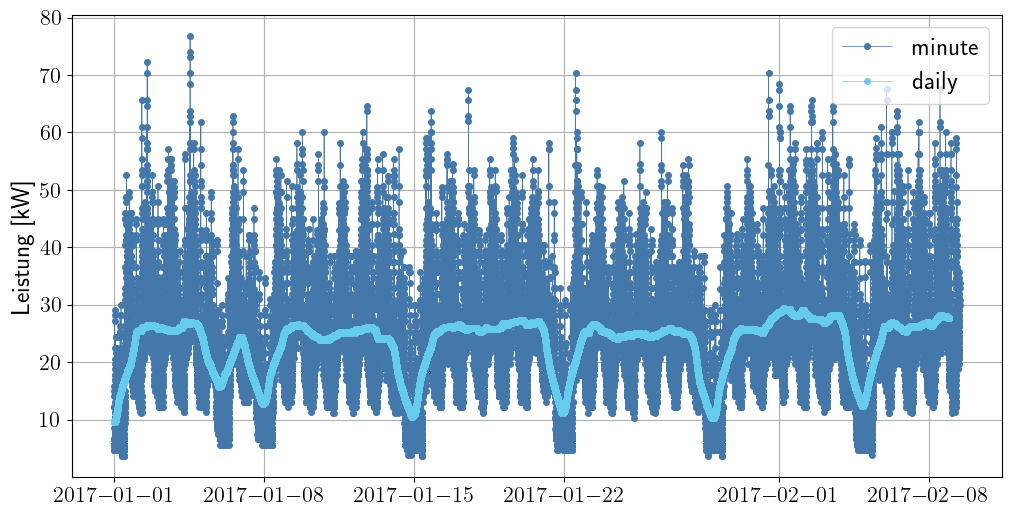

In [47]:
start, end = '2017-01', '2017-02'
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df2.loc[start:end, 'industrialP'], 
       marker = '.', linestyle = '-', linewidth = 0.5,
        label = 'minute')
ax.plot(df2_1d.loc[start:end],
       marker = '.', linestyle = '-', linewidth = 0.5,
        label = 'daily')
ax.set_ylabel('Leistung [kW]')
ax.legend()
ax.grid()

Fensterungsergebnis hat die gleiche Auflösung wie das ursprüngliche Datenset, aber ist etwas geglättet

Hier kann man Trends und Wiederholungseffekte besser erkennen.

Manchmal sind Datensätze auch sehr hochaufgelöst (für non-intrusive load monitoring, NILM), dann muss man die erst (jupyter notebook unter `files/nb/Hochaufgeloeste_Daten_downsamplen.ipynb`) mitteln, um sie auf kleineren Rechnern handhabbar zu haben. 

## Histogramm der Leistungswerte

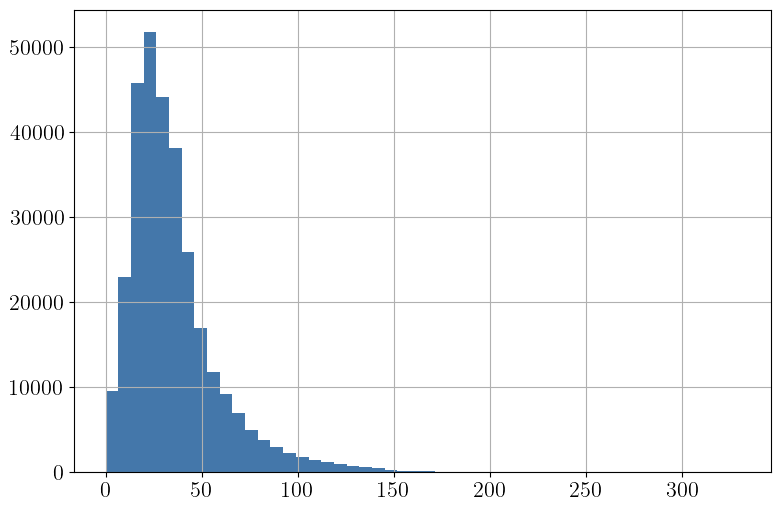

In [48]:
plt.figure(figsize=(9,6))
df2['industrialP'].hist(bins = 50)
plt.show()

Hier ist deutlich zu sehen, welche Leistungswerte besonders häufig vorkommen. Allerdings ist die y-Achsen-Skalierung mit Vorsicht zu genießen ...

## Heatmaps erzeugen

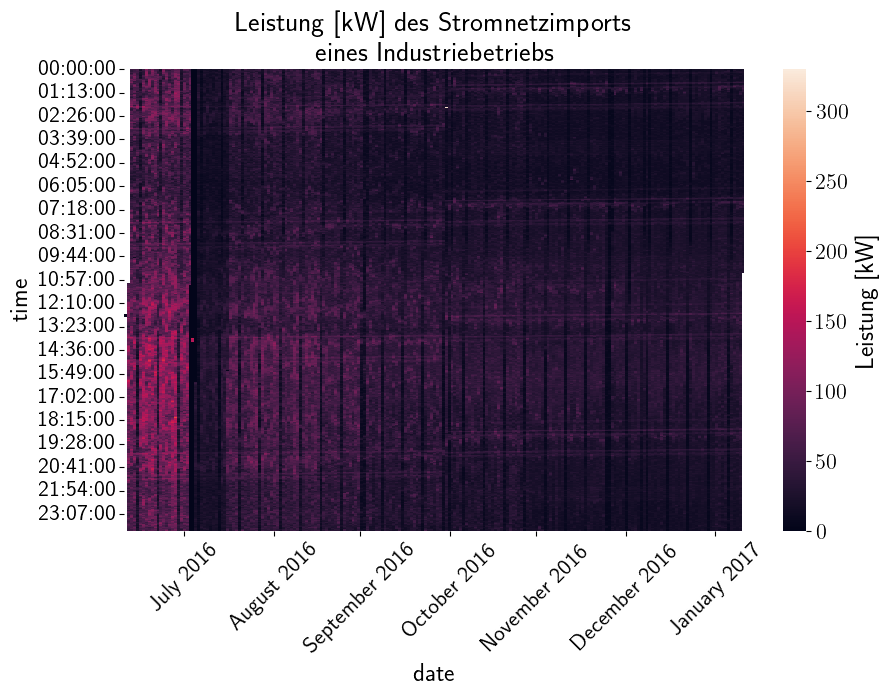

In [49]:
hm_df = pd.DataFrame({'industrialP': df2['industrialP']})
hm_df['date'] = df2.index.date
hm_df['time'] = df2.index.time
hm_piv = hm_df.pivot(index = 'time', columns = 'date', values = 'industrialP')
fig, ax = plt.subplots(figsize = (10,6))
sns.heatmap(hm_piv, cbar_kws={'label': 'Leistung [kW]'})
ax.set_title('Leistung [kW] des Stromnetzimports\n eines Industriebetriebs')
set_date_ticks(ax, hm_piv.columns[0], hm_piv.columns[-1] ,axis='x', freq='1ME', date_format='%B %Y')
ax.tick_params(axis="x", rotation=45)

Es lassen sich hier gewisse Regelmäßigkeiten erkennen: z. B. dass immer wieder dunkle Striche sind, die offenbar im Wochenrhythmus auftreten und suggerieren, dass eine eher geringe Standby-Leistung vorhanden ist. Auch nachts (früh morgens) scheint der Bedarf gering zu sein.

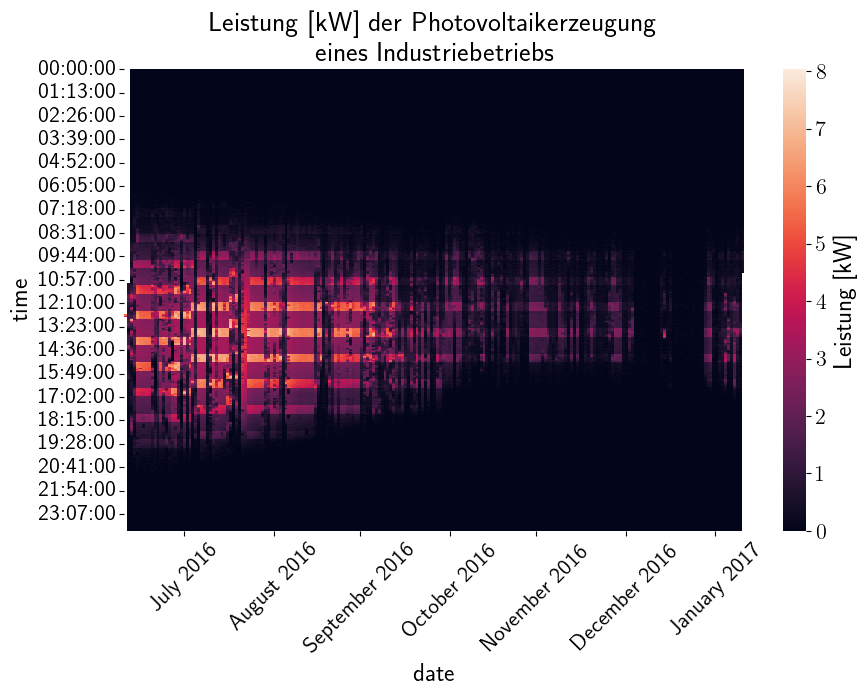

In [50]:
hm2_df = pd.DataFrame({'pvP': df2['pvP']})
hm2_df['date'] = df2.index.date
hm2_df['time'] = df2.index.time
hm2_piv = hm2_df.pivot(index = 'time', columns = 'date', values = 'pvP')
fig1, ax1 = plt.subplots(figsize = (10,6))
sns.heatmap(hm2_piv, cbar_kws={'label': 'Leistung [kW]'})
ax1.set_title('Leistung [kW] der Photovoltaikerzeugung\n eines Industriebetriebs')
set_date_ticks(ax1, hm2_piv.columns[0], hm2_piv.columns[-1] ,axis='x', freq='1ME', date_format='%B %Y')
ax1.tick_params(axis="x", rotation=45)

## Sankey-Diagramme erzeugen

(np.float64(-1.7849478967296384),
 np.float64(1.4),
 np.float64(-1.9947228045239584),
 np.float64(1.4))

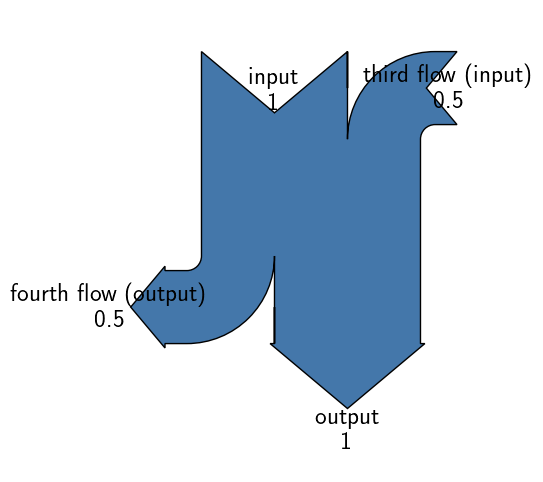

In [51]:
from matplotlib.sankey import Sankey

fig, ax = plt.subplots(figsize = [6,6])
sankey = Sankey(ax=ax)
sankey.add(flows=[1, -1, 0.5, -0.5],
orientations=[0, 0, 1, -1],
labels=['input', 'output', 'third flow (input)', 'fourth flow (output)'],
rotation=-90)
sankey.finish()
ax.axis('off')
#plt.show()

### Formale Anforderungen an ein Sankey-Diagramm

- Breite der Pfeile proportional zur Prozentzahl
- Knotenregel gilt: Summe der Flüsse hinein in ein System muss gleich der Summe der Flüsse hinaus sein
- Flüsse müssen dieselbe Einheit haben, z. B. Energie, Leistung, Material, $CO_2$

### Zum Schmunzeln: ein Sankey-Diagramm ohne Energiebezug

[Wen Trump 2017 auf Twitter am meisten attackierte](https://www.axios.com/who-trump-attacks-the-most-on-twitter-1513305449-f084c32e-fcdf-43a3-8c55-2da84d45db34.html) {cite:p}`kight_who_2017`

:::{bibliography}
:filter: docname in docnames
:::